Case Study
---
Do you want to buy a new laptop? If yes, what is your concern?, Price, or its equipment?

Before making the decision, let us explore the price of laptop.

To make the accurate information, 
1. we will make a detailed Exploratory Data Analysis (EDA), or called data washing; 
2. create a model for prediction of the value of laptop; 
3. Deployment of the Model.


Skills of Pandas manipulation
---
1. `df['Memory].unique()`, set of terms in this feature; 特徵項目
2. `df['Memory].value_counts()`, count of each unique term in this feature; 這陣子項目數量
3. `df["Memory"].str.split(pat=pattern,expand=True)`, split string into different features, by using `pattern` as the delimiter string. 依照特徵分解特徵值
4.  Extract the part of digits, where  
```
# more than one digit, 包含至少一個數字
pattern='(\d+)'
df['Memory'].str.extract(pattern,expand=True)
```
5. Extract the part of letters, 包含至少一個英文字母
```
# more than one letter, capital or not
pattern='([A-Za-z+]+)'
df['Memory'].str.extract(pattern,expand=True)
```

In [1]:
import pandas as pd 
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
# pkg for interactive vis

import warnings
warnings.filterwarnings('ignore')
#把warning省略掉

%matplotlib inline

Using lux
---
Lux helps pandas DataFrame to visualize output automatically and efficiently. Lux 用視覺化的方式，幫忙找出數據之間的關係

```
[installation and Usage]
# installation 安裝方式
!pip install lux-api

# use on Google drive, 在 Google Drive 上面使用
from google.colab import output
output.enable_custom_widget_manager()


import lux
df = ...
df
# click [Toggle Pandas/Lux] to work, 啟動

# or use by chosen target, "Price",依照某個參數觀察
df.intent = ["Price"]
df
```

In [6]:
# Data, 資料來源
file="https://raw.githubusercontent.com/Raghavagr/Laptop_Price_Prediction/main/laptop_data.csv"
#file="Laptop_prive.csv"

df = pd.read_csv(file) 

In [10]:
# save the data without index, 如果要存檔

df.to_csv("Laptop_prive.csv",index=0)

In [3]:
df.head()

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


Value of Laptop, 手提電腦的價值
---
Value of laptop is certainly included the following equipments, 手提電腦的價值包含下列設備:
```
Company
TypeName
Inches
ScreenResolution
CPU
GPU
Memory
OP sys
Ram
```
To predict the value, we have to get out the "RIGHT" information of data by EDA. 利用 EDA 取出正確的資料來估計價值

In [7]:
# delete the useless feature, 消除沒用的欄位，

df.drop(columns=['Unnamed: 0'],inplace=True)

## remove gb and kg from Ram and weight and convert the cols to numeric, 除掉去除單位，留下數目字

df['Ram'] = df['Ram'].str.replace("GB", "")
df['Weight'] = df['Weight'].str.replace("kg", "")
df['Ram'] = df['Ram'].astype('int32')
df['Weight'] = df['Weight'].astype('float32')

# Transform unit of price and make it in hundreds, 轉換價值單位，並最小為 00 計價  
df['Price'] = ((0.39*df['Price']//100)*100).astype('int')

# Prediction


[Regression Prediction, pycaret](#Prediction-by-Pycaret)
1. first case:
```
features=['Ram','Weight']
target='Price']
```

Exploratory Data Analysis, EDA
---

CPU and GPU
---
Only companies and running velocity to be extracted, 使用哪一家的中央處理器，和執行速度
1. companies: Intel ( `core i*` or `not`) , AMD, others
2. velocity: `%d.%d`GHz

Steps
---
1. Classify what kind of CPU, 中央處理器的品牌: 
    - Intel:  a) `core-i` series or b) `not Intel core-i`, 
    - `AMD`
    - and `others`

```
# split by space, get the first 3 words, e.g. Intel Core i7, 取出前面三個資料

" ".join(x.split()[0:3])
```
2. velocity of CPU, extract the string `*.*` from `*.*GHz` and convert it to float, 取出執行速度，去掉單位並轉為小數:
```
# define the pattern, at least one digit after . and before GHz
pattern='([.\d]+GHz)'
df['CPU_vel']=(df['Cpu'].str.extract(pattern,expand=True))
# convert to float
df['CPU_vel']=df['Cpu'].apply(lambda x: str(x)[:-3]).astype(float)
```

3. Company of GPU, Intel, Nvidia, AMD or other, 圖形處理器的品牌:
```
pattern=' '
df['GPU']=df['Gpu'].str.split(pat=pattern,expand=True)[0]
```

In [67]:
# CPU data

df['Cpu'].unique()

array(['Intel Core i5 2.3GHz', 'Intel Core i5 1.8GHz',
       'Intel Core i5 7200U 2.5GHz', 'Intel Core i7 2.7GHz',
       'Intel Core i5 3.1GHz', 'AMD A9-Series 9420 3GHz',
       'Intel Core i7 2.2GHz', 'Intel Core i7 8550U 1.8GHz',
       'Intel Core i5 8250U 1.6GHz', 'Intel Core i3 6006U 2GHz',
       'Intel Core i7 2.8GHz', 'Intel Core M m3 1.2GHz',
       'Intel Core i7 7500U 2.7GHz', 'Intel Core i7 2.9GHz',
       'Intel Core i3 7100U 2.4GHz', 'Intel Atom x5-Z8350 1.44GHz',
       'Intel Core i5 7300HQ 2.5GHz', 'AMD E-Series E2-9000e 1.5GHz',
       'Intel Core i5 1.6GHz', 'Intel Core i7 8650U 1.9GHz',
       'Intel Atom x5-Z8300 1.44GHz', 'AMD E-Series E2-6110 1.5GHz',
       'AMD A6-Series 9220 2.5GHz',
       'Intel Celeron Dual Core N3350 1.1GHz',
       'Intel Core i3 7130U 2.7GHz', 'Intel Core i7 7700HQ 2.8GHz',
       'Intel Core i5 2.0GHz', 'AMD Ryzen 1700 3GHz',
       'Intel Pentium Quad Core N4200 1.1GHz',
       'Intel Atom x5-Z8550 1.44GHz',
       'Intel Celeron Du

In [206]:
pattern='(\d.\dGHz)'
df['Cpu'].str.extract(pattern,expand=True)

,0
0,2.3GHz
1,1.8GHz
2,2.5GHz
3,2.7GHz
4,3.1GHz
...,...
1298,2.5GHz
1299,2.5GHz
1300,1.6GHz
1301,2.5GHz


In [9]:
#first we will extract Name of CPU which is first 3 words from Cpu column and then we will check which processor it is
def fetch_processor(x):
  cpu_name = " ".join(x.split()[0:3])
  if cpu_name == 'Intel Core i7' or cpu_name == 'Intel Core i5' or cpu_name == 'Intel Core i3':
    return cpu_name
  elif cpu_name.split()[0] == 'Intel':
    return 'Other Intel Processor'
  elif cpu_name.split()[0] == 'AMD':
    return cpu_name    
  else:
    return 'Others Processor'

def EDA_CPU(df_,f_='Cpu'):
    pattern='([.\d]+GHz)'
    df_['CPU_vel']=(df_[f_].str.extract(pattern,expand=True))
    df_['CPU_vel']=df_['CPU_vel'].apply(lambda x: str(x)[:-3]).astype(float)
    return df_

df['Cpu_brand'] = df['Cpu'].apply(lambda x: fetch_processor(x))
df=EDA_CPU(df)


In [10]:
df[['Cpu','Cpu_brand','CPU_vel']].head()

,Cpu,Cpu_brand,CPU_vel
0,Intel Core i5 2.3GHz,Intel Core i5,2.3
1,Intel Core i5 1.8GHz,Intel Core i5,1.8
2,Intel Core i5 7200U 2.5GHz,Intel Core i5,2.5
3,Intel Core i7 2.7GHz,Intel Core i7,2.7
4,Intel Core i5 3.1GHz,Intel Core i5,3.1


In [11]:
def EDA_GPU(df_,f_='Gpu'):
    pattern=' '
    df_['GPU']=df_[f_].str.split(pat=pattern,expand=True)[0]
    return df_

df=EDA_GPU(df)

In [12]:
df[['Cpu','Cpu_brand','CPU_vel','Gpu','GPU']].head()

,Cpu,Cpu_brand,CPU_vel,Gpu,GPU
0,Intel Core i5 2.3GHz,Intel Core i5,2.3,Intel Iris Plus Graphics 640,Intel
1,Intel Core i5 1.8GHz,Intel Core i5,1.8,Intel HD Graphics 6000,Intel
2,Intel Core i5 7200U 2.5GHz,Intel Core i5,2.5,Intel HD Graphics 620,Intel
3,Intel Core i7 2.7GHz,Intel Core i7,2.7,AMD Radeon Pro 455,AMD
4,Intel Core i5 3.1GHz,Intel Core i5,3.1,Intel Iris Plus Graphics 650,Intel


2. Second case:
```
features=['Ram','Weight','Cpu','Cpu_brand','CPU_vel','Gpu','GPU']
target='Price']
```

<AxesSubplot: xlabel='Price', ylabel='Density'>

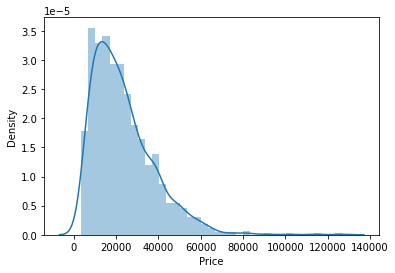

In [13]:
sns.distplot(df['Price'])


EDA of Memory
---
This feature contains the specification of storage, which is highly related the selling price of device. The format
of feature includes the following, 硬碟配備數目和容量大小:

1. `digit(s) letters`, 硬碟容量大小 硬碟種類: 
```
digits: size of memory, null, 2, 8, 16 ...,
letters: type of storages, SSD, Flash Storage, HDD, Hybrid
```
2.` * + *`: more than two kinds of storages equipment, 兩個硬碟使用 "+" 隔開:
```
256(512) SSD + 256 SSD, 256 SSD + HDD, 64 Flash Storage + HDD, 256(512) SSD + Hybrid, HDD + HDD
```

And the important factors are:
1. kind of storage, `HDD, SSD, Flash Storage`, 硬碟種類，其他;
2. number of storages: 1, or 2 (hybrid, or cell, containing `+`)，一個或兩個硬碟
3. size of each storage:, 1, 2, 16, 64, 256, 512，硬碟容量;
4. others (?)，其他

Skills of Pandas manipulation
---
1. `df['Memory].unique()`, set of terms in this feature;
2. `df['Memory].value_counts()`, count of each unique term in this feature;
3. `df["Memory"].str.split(pat=pattern,expand=True)`, split string into different features, by using `pattern` as the delimiter string.
4.  Extract the part of digits, where  
```
# more than one digit
pattern='(\d+)'
df['Memory'].str.extract(pattern,expand=True)
```
5. Extract the part of letters, 
```
# more than one letter, capital or not
pattern='([A-Za-z+]+)'
df['Memory'].str.extract(pattern,expand=True)
```

Steps
---
Every set has storage no more than two.  最多只有兩個硬碟
1. split to `first` or `second`，分開不同的硬碟裝置.
2. In each part of `1.`, extract `size` and `type`，分別取出容量大小和型態
3. four new features created，共有四個新特徵產生:
```
fist_size, first_type,  second_size, second_type
``` 

In [8]:
df['Memory'].unique()

array(['128GB SSD', '128GB Flash Storage', '256GB SSD', '512GB SSD',
       '500GB HDD', '256GB Flash Storage', '1TB HDD',
       '32GB Flash Storage', '128GB SSD +  1TB HDD',
       '256GB SSD +  256GB SSD', '64GB Flash Storage',
       '256GB SSD +  1TB HDD', '256GB SSD +  2TB HDD', '32GB SSD',
       '2TB HDD', '64GB SSD', '1.0TB Hybrid', '512GB SSD +  1TB HDD',
       '1TB SSD', '256GB SSD +  500GB HDD', '128GB SSD +  2TB HDD',
       '512GB SSD +  512GB SSD', '16GB SSD', '16GB Flash Storage',
       '512GB SSD +  256GB SSD', '512GB SSD +  2TB HDD',
       '64GB Flash Storage +  1TB HDD', '180GB SSD', '1TB HDD +  1TB HDD',
       '32GB HDD', '1TB SSD +  1TB HDD', '512GB Flash Storage',
       '128GB HDD', '240GB SSD', '8GB SSD', '508GB Hybrid', '1.0TB HDD',
       '512GB SSD +  1.0TB Hybrid', '256GB SSD +  1.0TB Hybrid'],
      dtype=object)

In [14]:
def EDA_Memory(df_,f_='Memory'):
    # split storage(s)
    # remove GB unit
    # convert TB to 1000
    # remove .0
    df1=df_.copy()
    df1[f_] = df1[f_].astype(str).replace('.0', '', regex=True)
    df1[f_] = df1[f_].str.replace('GB', '')
    df1[f_] = df1[f_].str.replace('TB', '000')
    
    # determine whether therr are two units of stoages or not
    pattern="+"
    devices = (df1[f_].str.split(pat=pattern,expand=True))
    
    # the first device
    pat1=" "
    dev0 = (devices[0].str.split(pat=pat1,expand=True))
    
    # size of storage
    pattern_1='(\d+)'
    s1=list(devices[0].str.extract(pattern_1,expand=True)[0])
    s2=list(devices[1].str.extract(pattern_1,expand=True)[0])
    # type of storage
    pattern_2='([A-Za-z+]+)'
    t1=list(devices[0].str.extract(pattern_2,expand=True)[0])
    t2=list(devices[1].str.extract(pattern_2,expand=True)[0])
    # Create features of storages
    df1['first_size']=s1
    df1['first_type']=t1
    df1['second_size']=s2
    df1['second_type']=t2
    df1['first_size'].fillna(0,inplace=True)
    df1['second_size'].fillna(0,inplace=True)
    df1['second_type'].fillna(0,inplace=True)
    df1['first_size']=df1['first_size'].astype(int)
    df1['second_size']=df1['second_size'].astype(int)
    return df1

In [15]:
#df1=df[['Memory']].copy()
df=EDA_Memory(df,f_='Memory')


In [16]:
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,Cpu_brand,CPU_vel,GPU,first_size,first_type,second_size,second_type
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128 SSD,Intel Iris Plus Graphics 640,macOS,1.37,27800,Intel Core i5,2.3,Intel,128,SSD,0,0
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128 Flash Storage,Intel HD Graphics 6000,macOS,1.34,18600,Intel Core i5,1.8,Intel,128,Flash,0,0
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256 SSD,Intel HD Graphics 620,No OS,1.86,11900,Intel Core i5,2.5,Intel,256,SSD,0,0
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512 SSD,AMD Radeon Pro 455,macOS,1.83,52700,Intel Core i7,2.7,AMD,512,SSD,0,0
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256 SSD,Intel Iris Plus Graphics 650,macOS,1.37,37400,Intel Core i5,3.1,Intel,256,SSD,0,0


In [18]:
df['first_type'].unique()

array(['SSD', 'Flash', 'HDD', 'Hybrid'], dtype=object)

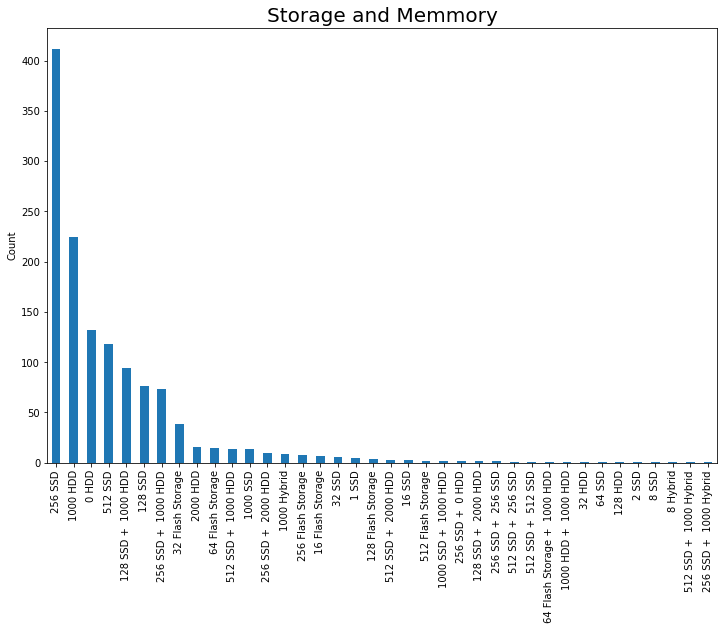

In [20]:
plt.figure(figsize=(12,8))
plt.title("Storage and Memmory",size=20)
df['Memory'].value_counts().plot(kind='bar',ylabel='Count');

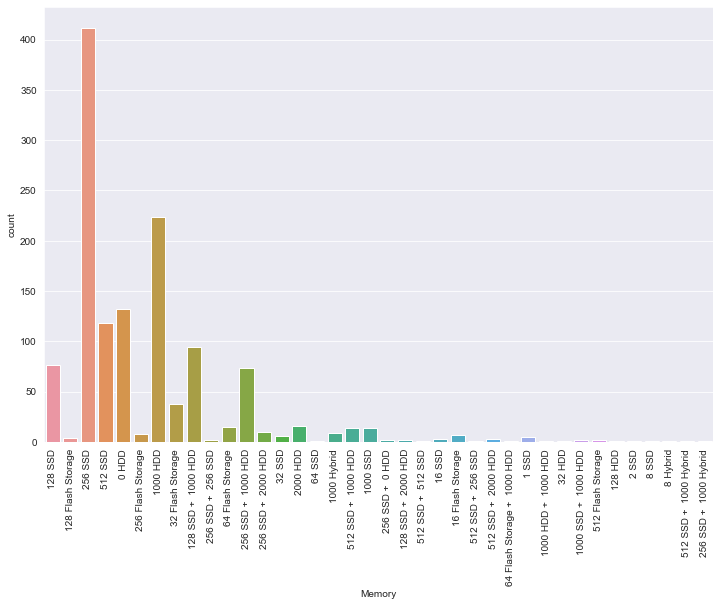

In [21]:
plt.figure(figsize=(12,8))

sns.set_style('darkgrid')
sns.countplot(data=df,x='Memory')
plt.xticks(rotation="vertical");

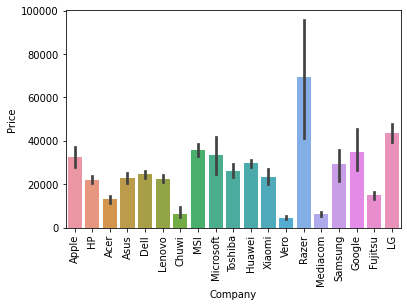

In [32]:
#what is avg price of each brand?

sns.barplot(x=df['Company'], y=df['Price'])

plt.xticks(rotation="vertical");

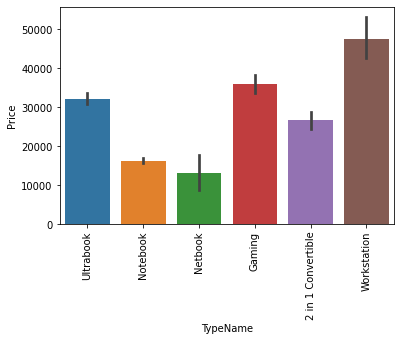

In [34]:
#data['TypeName'].value_counts().plot(kind='bar')
sns.barplot(x=df['TypeName'], y=df['Price'])
plt.xticks(rotation="vertical");

<AxesSubplot:xlabel='Inches', ylabel='Price'>

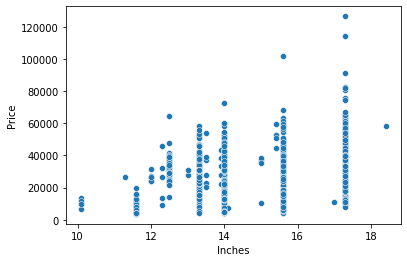

In [35]:
sns.scatterplot(x=df['Inches'],y=df['Price'])


<AxesSubplot: xlabel='Touchscreen', ylabel='Price'>

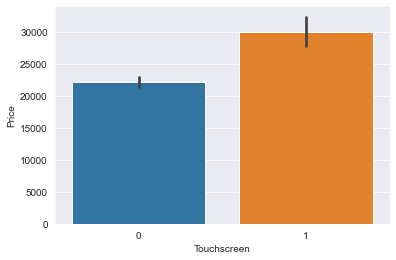

In [22]:
# whether is Touchscreen or not, 是否為觸控面板
df['Touchscreen'] = df['ScreenResolution'].apply(lambda x:1 if 'Touchscreen' in x else 0)
#how many laptops in data are touchscreen
sns.countplot(df['Touchscreen'])
#Plot against price
sns.barplot(x=df['Touchscreen'],y=df['Price'])

<AxesSubplot: xlabel='Ips', ylabel='Price'>

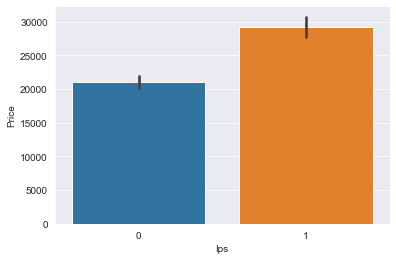

In [23]:
# whether  IPS is, 是否為硬版 
df['Ips'] = df['ScreenResolution'].apply(lambda x:1 if 'IPS' in x else 0)
sns.barplot(x=df['Ips'],y=df['Price'])

In [24]:
# X-Y resolution, X, Y 解析度
def findXresolution(s):
  return s.split()[-1].split("x")[0]
def findYresolution(s):
  return s.split()[-1].split("x")[1]
#finding the x_res and y_res from screen resolution
df['X_res'] = df['ScreenResolution'].apply(lambda x: findXresolution(x))
df['Y_res'] = df['ScreenResolution'].apply(lambda y: findYresolution(y))
#convert to numeric
df['X_res'] = df['X_res'].astype('int')
df['Y_res'] = df['Y_res'].astype('int')

In [25]:
# Pixel per inches(PPI), having a strong correlatsolution, ion, PPI 解析度
df['ppi'] = (((df['X_res']**2) + (df['Y_res']**2))**0.5/df['Inches']).astype('float')
df.corr()['Price'].sort_values(ascending=False)

Price          1.000000
Ram            0.742876
X_res          0.556480
Y_res          0.552757
ppi            0.473446
CPU_vel        0.430313
second_size    0.293982
Ips            0.252150
Weight         0.210373
Touchscreen    0.191211
Inches         0.068191
first_size    -0.021216
Name: Price, dtype: float64

In [42]:
#df.drop(columns = ['ScreenResolution', 'Inches','X_res','Y_res'], inplace=True)


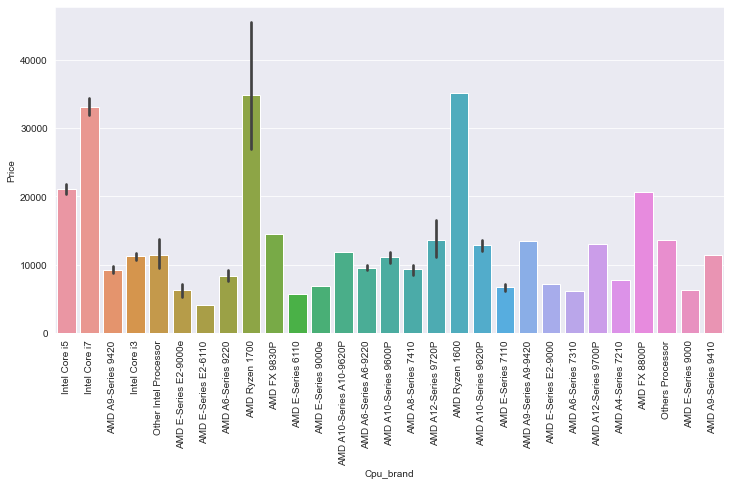

In [27]:
plt.figure(figsize=(12,6))
sns.barplot(x=df['Cpu_brand'],y=df['Price'])
plt.xticks(rotation='vertical');

<AxesSubplot: xlabel='Ram', ylabel='Price'>

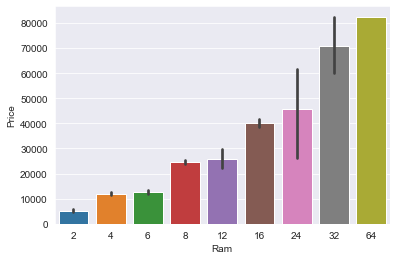

In [28]:
sns.barplot(df['Ram'], df['Price'])

In [29]:
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,...,GPU,first_size,first_type,second_size,second_type,Touchscreen,Ips,X_res,Y_res,ppi
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128 SSD,Intel Iris Plus Graphics 640,macOS,1.37,...,Intel,128,SSD,0,0,0,1,2560,1600,226.983005
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128 Flash Storage,Intel HD Graphics 6000,macOS,1.34,...,Intel,128,Flash,0,0,0,0,1440,900,127.677940
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256 SSD,Intel HD Graphics 620,No OS,1.86,...,Intel,256,SSD,0,0,0,0,1920,1080,141.211998
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512 SSD,AMD Radeon Pro 455,macOS,1.83,...,AMD,512,SSD,0,0,0,1,2880,1800,220.534624
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256 SSD,Intel Iris Plus Graphics 650,macOS,1.37,...,Intel,256,SSD,0,0,0,1,2560,1600,226.983005


In [43]:

#first we will extract Name of CPU which is first 3 words from Cpu column and then we will check which processor it is
def fetch_processor(x):
  cpu_name = " ".join(x.split()[0:3])
  if cpu_name == 'Intel Core i7' or cpu_name == 'Intel Core i5' or cpu_name == 'Intel Core i3':
    return cpu_name
  elif cpu_name.split()[0] == 'Intel':
    return 'Other Intel Processor'
  else:
    return 'AMD Processor'
df['Cpu_brand'] = df['Cpu'].apply(lambda x: fetch_processor(x))

In [ ]:
# Which brand GPU is in laptop
data['Gpu_brand'] = data['Gpu'].apply(lambda x:x.split()[0])
#there is only 1 row of ARM GPU so remove it
data = data[data['Gpu_brand'] != 'ARM']
data.drop(columns=['Gpu'],inplace=True)

In [30]:
# Get which OP sys, 作業系統資料
def cat_os(inp):
    if inp == 'Windows 10' or inp == 'Windows 7' or inp == 'Windows 10 S':
        return 'Windows'
    elif inp == 'macOS' or inp == 'Mac OS X':
        return 'Mac'
    else:
        return 'Others/No OS/Linux'
df['os'] = df['OpSys'].apply(cat_os)
#data.drop(columns=['OpSys'],inplace=True)

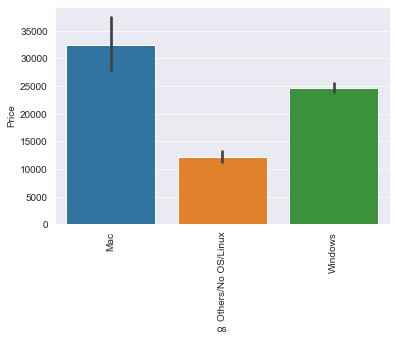

In [31]:
sns.barplot(x=df['os'],y=df['Price'])
plt.xticks(rotation='vertical');


In [ ]:
# skew solved
sns.distplot(np.log(data['Price']));

# Prediction by Pycaret

In [ ]:
!pip install --pre --no-deps pycaret

In [126]:
df.columns

Index(['Company', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram',
       'Memory', 'Gpu', 'OpSys', 'Weight', 'Price', 'Cpu_brand', 'CPU_vel',
       'GPU', 'first_size', 'first_type', 'second_size', 'second_type',
       'Touchscreen', 'Ips', 'X_res', 'Y_res', 'ppi', 'os',
       'Company_name_encoded', 'TypeName_name_encoded',
       'Cpu_brand_name_encoded', 'first_type_name_encoded',
       'second_type_name_encoded'],
      dtype='object')

In [34]:
df.head().T

,0,1,2,3,4
Company,Apple,Apple,HP,Apple,Apple
TypeName,Ultrabook,Ultrabook,Notebook,Ultrabook,Ultrabook
Inches,13.3,13.3,15.6,15.4,13.3
ScreenResolution,IPS Panel Retina Display 2560x1600,1440x900,Full HD 1920x1080,IPS Panel Retina Display 2880x1800,IPS Panel Retina Display 2560x1600
Cpu,Intel Core i5 2.3GHz,Intel Core i5 1.8GHz,Intel Core i5 7200U 2.5GHz,Intel Core i7 2.7GHz,Intel Core i5 3.1GHz
...,...,...,...,...,...
Ips,1,0,0,1,1
X_res,2560,1440,1920,2880,2560
Y_res,1600,900,1080,1800,1600
ppi,226.983005,127.67794,141.211998,220.534624,226.983005


In [66]:
# numberical feature, 數字化資料
num_features=['Inches','Ram','CPU_vel','GPU','Touchscreen', 'Ips', 'X_res', 'Y_res', 'ppi','first_size', 'second_size']
# catigorical data，種類資料
cat_features=['Company', 'TypeName','Cpu_brand', 'first_type', 'second_type']
# target 目標參數
target=['Price']

In [6]:
df['Price1']=df['Price'].apply(lambda x:np.log(x))

In [7]:
df[['Price','Price1']].head()

,Price,Price1
0,27800,10.232791
1,18600,9.830917
2,11900,9.384294
3,52700,10.872371
4,37400,10.529426


In [36]:
from pycaret.regression import *


In [67]:
# setup pycaret regression model, 設定 Pycaret 回歸模型
data=df[num_features+cat_features+target]

reg1 = setup(data = data, target = 'Price')

,Description,Value
0,Session id,1598
1,Target,Price
2,Target type,Regression
3,Data shape,"(1303, 25)"
4,Train data shape,"(912, 25)"
5,Test data shape,"(391, 25)"
6,Numeric features,10
7,Categorical features,6
8,Preprocess,True
9,Imputation type,simple


In [38]:
# types of models availed, 提供的模型
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.ElasticNet,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
...,...,...,...
mlp,MLP Regressor,sklearn.neural_network._multilayer_perceptron.MLPRegressor,False
xgboost,Extreme Gradient Boosting,xgboost.sklearn.XGBRegressor,True
lightgbm,Light Gradient Boosting Machine,lightgbm.sklearn.LGBMRegressor,True


In [68]:
# Compare models, 各種模型的比較
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,5344.3367,57687411.3863,7527.5526,0.7111,0.2992,0.2529,0.0250
ridge,Ridge Regression,5367.2443,58207949.2740,7561.6213,0.7081,0.3017,0.2540,0.0240
lasso,Lasso Regression,5367.8119,58227272.3466,7563.1623,0.7079,0.3018,0.2539,0.0540
lr,Linear Regression,5368.3012,58240077.5098,7564.0703,0.7078,0.3019,0.2540,0.7080
en,Elastic Net,5437.3747,59366234.3995,7632.1164,0.7039,0.3042,0.2627,0.0270
et,Extra Trees Regressor,5830.0616,66179073.9223,7975.0360,0.6841,0.3301,0.3078,0.0920
omp,Orthogonal Matching Pursuit,6358.4186,74322891.0090,8565.2845,0.6284,0.3771,0.3425,0.0250
catboost,CatBoost Regressor,6297.5190,79928259.8262,8790.4335,0.6172,0.3636,0.3380,0.9310
gbr,Gradient Boosting Regressor,6298.1270,81047948.8179,8849.5503,0.6118,0.3604,0.3318,0.0560
br,Bayesian Ridge,6290.0341,82659591.9729,8967.9807,0.5976,0.3408,0.3022,0.0250


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

LassoLars(random_state=1598)

Note
---
1. There are more than 20 models testd, awesome.
2. How many model do you know? `lr` mesns `linear regression` only, right? But it is not the best one of tested models, from the measures:
   - MAE, Mean Absolute Error
$$\text{ MSE } = \frac{1}{n}\sum_i|y_i-\hat y_i|$$   
   - MSE, Mean Square Error
$$\text{ MSE } = \frac{1}{n}\sum_i(y_i-\hat y_i)^2$$ 
3. Here suggests the best one is `catboost`, a tree-based regression.

In [69]:
lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5170.1545,45098953.6067,6715.5754,0.6567,0.3187,0.2635
1,5125.5648,47929225.8878,6923.0937,0.8070,0.2852,0.2568
2,5879.6714,88986087.6287,9433.2437,0.6087,0.2981,0.2441
3,5160.4448,55119413.8564,7424.2450,0.7401,0.3030,0.2581
4,5714.3688,88269475.7374,9395.1836,0.7235,0.2858,0.2293
5,5547.8397,49415310.7212,7029.6025,0.7660,0.3220,0.2831
6,5208.1822,55067194.9304,7420.7274,0.6751,0.2938,0.2297
7,5337.1472,46029303.2529,6784.4899,0.7605,0.3296,0.2800
8,5730.0708,64248403.5931,8015.5102,0.6069,0.2930,0.2490


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [70]:
pred_lr = predict_model(lr)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,5150.3854,59682607.2317,7725.4519,0.7356,0.2961,0.2343


In [71]:
pred_lr.columns

Index(['Inches', 'Ram', 'CPU_vel', 'GPU_Intel', 'GPU_Nvidia', 'GPU_AMD',
       'Touchscreen', 'Ips', 'X_res', 'Y_res', 'ppi', 'first_size',
       'second_size', 'Company', 'TypeName', 'Cpu_brand', 'first_type_SSD',
       'first_type_HDD', 'first_type_Flash', 'first_type_Hybrid',
       'second_type_0', 'second_type_HDD', 'second_type_Hybrid',
       'second_type_SSD', 'Price', 'prediction_label'],
      dtype='object')

In [48]:
data.columns

Index(['Inches', 'Ram', 'CPU_vel', 'GPU', 'Touchscreen', 'Ips', 'X_res',
       'Y_res', 'ppi', 'first_size', 'Company', 'TypeName', 'Cpu_brand',
       'first_type', 'second_type', 'second_size', 'Price'],
      dtype='object')

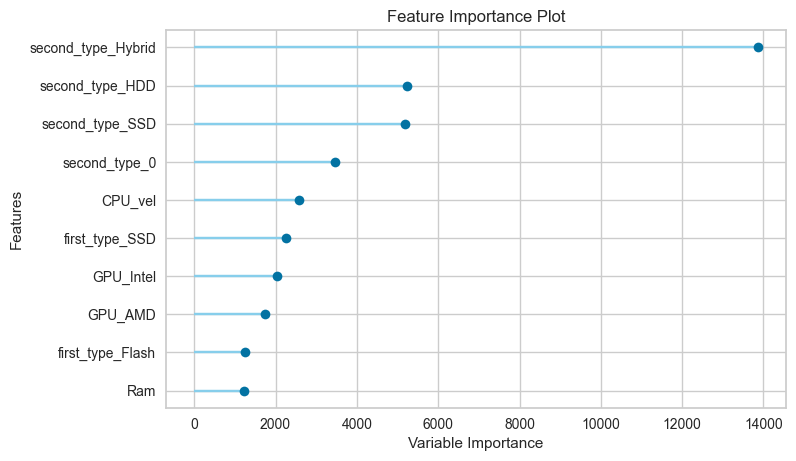

In [72]:
# Plot of Feature Importance
plot_model(lr, plot='feature')

In [55]:
lr.feature_names_in_

array(['Inches', 'Ram', 'CPU_vel', 'GPU_Intel', 'GPU_Nvidia', 'GPU_AMD',
       'GPU_ARM', 'Touchscreen', 'Ips', 'X_res', 'Y_res', 'ppi',
       'first_size', 'Company', 'TypeName', 'Cpu_brand',
       'first_type_Flash', 'first_type_SSD', 'first_type_HDD',
       'first_type_Hybrid', 'second_type_0', 'second_type_HDD',
       'second_type_SSD', 'second_type_Hybrid', 'second_size'],
      dtype=object)

In [56]:
lr.coef_

array([-9.73221034e+02,  1.37298378e+03,  2.90911249e+03,  3.65887160e+03,
        1.74356281e+03, -1.38770148e+02, -5.26366426e+03, -1.20439953e+03,
        6.21788000e+02,  7.70785216e+00,  9.15684502e+00, -1.01454116e+02,
       -1.32761482e+00,  2.50130028e-01,  3.45709152e-01,  1.59043348e-01,
       -4.52389842e+02,  2.14022328e+03, -6.98060976e+02, -9.89772459e+02,
       -4.89683983e+02, -2.62706482e+03, -1.28032239e+04,  1.59199727e+04,
       -1.31264556e+00])

In [73]:
# print out the LRmodel,  線性回歸模型

print("Liner regression model:\nPrice = ")
for i in range(len(lr.feature_names_in_)):
      print('\t',lr.coef_[i]," ∘ ",lr.feature_names_in_[i])

Liner regression model:
Price = 
	 -1078.1450093692285  ∘  Inches
	 1219.0744178406246  ∘  Ram
	 2565.3803130939987  ∘  CPU_vel
	 2048.204412049433  ∘  GPU_Intel
	 -298.27418131006664  ∘  GPU_Nvidia
	 -1749.9302307404926  ∘  GPU_AMD
	 -619.7250843861998  ∘  Touchscreen
	 -234.50240930999215  ∘  Ips
	 5.9649805296895195  ∘  X_res
	 12.63422392181732  ∘  Y_res
	 -103.272520846499  ∘  ppi
	 -1.2801696097698994  ∘  first_size
	 -0.4650726194196295  ∘  second_size
	 0.15765992796306705  ∘  Company
	 0.39322363147502415  ∘  TypeName
	 0.19688709467027365  ∘  Cpu_brand
	 2268.657829104313  ∘  first_type_SSD
	 -236.1323243701317  ∘  first_type_HDD
	 -1239.6278153707624  ∘  first_type_Flash
	 -792.8976893634109  ∘  first_type_Hybrid
	 -3462.896072592234  ∘  second_type_0
	 -5223.749447758737  ∘  second_type_HDD
	 13861.247897589003  ∘  second_type_Hybrid
	 -5174.602377238043  ∘  second_type_SSD


Note
---
The quantities of  features ranges very large, from 10000 to 1. This makes the model unstable. And this comes from the fact of Pycaret auto-encoding on the categorical features. 從模型中，可以發覺到每個特徵值的係數範圍非常大，因此會造成模型的不穩定性，而這個原因是因為 pycaret 自動幫我們型態特徵編碼的關係. 

To reduce the un-stability, we can encode the categorical features before pycaret's work, 為了解決這個問題，我們可以在送到 pycaret 之前先行將這些型態特徵編碼。

In [82]:
# convert 0 to None id noe seconf storage, 如果沒有第二個硬碟，改為 None
df.loc[df['second_type'] == 0, 'second_type'] ='None'

In [83]:
# encoding manually, 編碼
from sklearn.preprocessing import LabelEncoder
def encoding(feature):
    df[feature+'_name_encoded'] = LabelEncoder().fit_transform(df[feature])
    
#cat_features=['Company','TypeName','OpSys','Cpu_brand']
for f_ in cat_features:
    encoding(f_)

In [90]:
cat_features=['Company_name_encoded', 'TypeName_name_encoded',
       'Cpu_brand_name_encoded', 'first_type_name_encoded',
       'second_type_name_encoded']

In [91]:
df[cat_features].head()

,Company_name_encoded,TypeName_name_encoded,Cpu_brand_name_encoded,first_type_name_encoded,second_type_name_encoded
0,1,4,25,3,2
1,1,4,25,0,2
2,7,3,25,3,2
3,1,4,26,3,2
4,1,4,25,3,2


In [92]:
# setup pycaret regression model, 設定 Pycaret 回歸模型
data=df[num_features+cat_features+target]

reg1 = setup(data = data, target = 'Price')

,Description,Value
0,Session id,1621
1,Target,Price
2,Target type,Regression
3,Data shape,"(1303, 20)"
4,Train data shape,"(912, 20)"
5,Test data shape,"(391, 20)"
6,Numeric features,15
7,Categorical features,1
8,Preprocess,True
9,Imputation type,simple


In [93]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,4060.5565,36885968.1209,6012.6549,0.8105,0.2216,0.1795,0.6090
lightgbm,Light Gradient Boosting Machine,4288.5814,39915748.7069,6272.1003,0.7967,0.2381,0.1928,0.1290
gbr,Gradient Boosting Regressor,4363.8853,40263321.1370,6303.5516,0.7935,0.2425,0.2022,0.0340
rf,Random Forest Regressor,4280.4093,40746074.1451,6331.0319,0.7896,0.2337,0.1888,0.0840
xgboost,Extreme Gradient Boosting,4387.5674,45040993.3756,6639.1208,0.7673,0.2414,0.1915,0.0550
et,Extra Trees Regressor,4413.1744,45468410.0153,6695.4351,0.7669,0.2493,0.1968,0.0870
llar,Lasso Least Angle Regression,5674.6211,59552580.9945,7653.1644,0.6961,0.3527,0.2877,0.0150
br,Bayesian Ridge,5673.4791,59734677.9581,7664.0068,0.6953,0.3457,0.2879,0.0150
ridge,Ridge Regression,5692.6345,59894917.7173,7674.3860,0.6947,0.3586,0.2888,0.0150
lr,Linear Regression,5694.3196,59914311.4857,7675.5894,0.6946,0.3592,0.2890,0.8070


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [94]:
lr2 = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6923.7114,85214097.3149,9231.1482,0.6862,0.3912,0.3428
1,4979.2358,43601522.8122,6603.1449,0.7547,0.2972,0.2590
2,5829.7267,59466272.6694,7711.4378,0.7072,0.4299,0.2772
3,5879.2890,65833645.9395,8113.7936,0.6643,0.3706,0.2836
4,4778.5398,36793343.3816,6065.7517,0.7572,0.3704,0.3068
5,6331.0322,76895459.7355,8769.0056,0.6757,0.3660,0.2908
6,5627.3820,69395036.5773,8330.3683,0.5660,0.3513,0.2959
7,5943.8844,68523134.8443,8277.8702,0.6147,0.3418,0.2875
8,5243.0999,42251513.4157,6500.1164,0.7830,0.3666,0.2932


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [95]:
pred_lr2 = predict_model(lr2)
pred_lr2

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,5989.0295,78501761.5067,8860.1220,0.6716,0.3343,0.2848


,Inches,Ram,CPU_vel,GPU_Intel,GPU_AMD,GPU_Nvidia,GPU_ARM,Touchscreen,Ips,X_res,...,ppi,first_size,second_size,Company_name_encoded,TypeName_name_encoded,Cpu_brand_name_encoded,first_type_name_encoded,second_type_name_encoded,Price,prediction_label
912,15.6,4.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1366.0,...,100.454666,0.0,0.0,0.0,3.0,24.0,1.0,2.0,9700,8612.050756
913,15.6,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1366.0,...,100.454666,1000.0,0.0,10.0,3.0,24.0,1.0,2.0,7000,9149.783743
914,15.6,8.0,2.5,0.0,1.0,0.0,0.0,0.0,0.0,1920.0,...,141.212006,256.0,0.0,7.0,5.0,26.0,3.0,2.0,31000,24858.134319
915,12.5,4.0,2.5,1.0,0.0,0.0,0.0,0.0,0.0,1366.0,...,125.367432,256.0,0.0,7.0,4.0,25.0,3.0,2.0,32300,19218.504221
916,14.0,8.0,2.6,0.0,0.0,1.0,0.0,1.0,1.0,1920.0,...,157.350510,512.0,0.0,10.0,0.0,26.0,3.0,2.0,42600,26667.662508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,15.6,16.0,2.8,0.0,0.0,1.0,0.0,0.0,0.0,1920.0,...,141.212006,256.0,1000.0,2.0,1.0,26.0,3.0,0.0,50800,38053.711980
1299,15.6,2.0,1.6,1.0,0.0,0.0,0.0,0.0,0.0,1366.0,...,100.454666,0.0,0.0,4.0,3.0,27.0,1.0,2.0,7800,4994.475278
1300,14.0,4.0,1.1,1.0,0.0,0.0,0.0,0.0,0.0,1920.0,...,157.350510,32.0,0.0,2.0,3.0,27.0,0.0,2.0,6100,7593.320367
1301,15.6,8.0,2.7,0.0,0.0,1.0,0.0,0.0,0.0,1920.0,...,141.212006,1000.0,0.0,7.0,3.0,26.0,1.0,2.0,18700,22577.903904


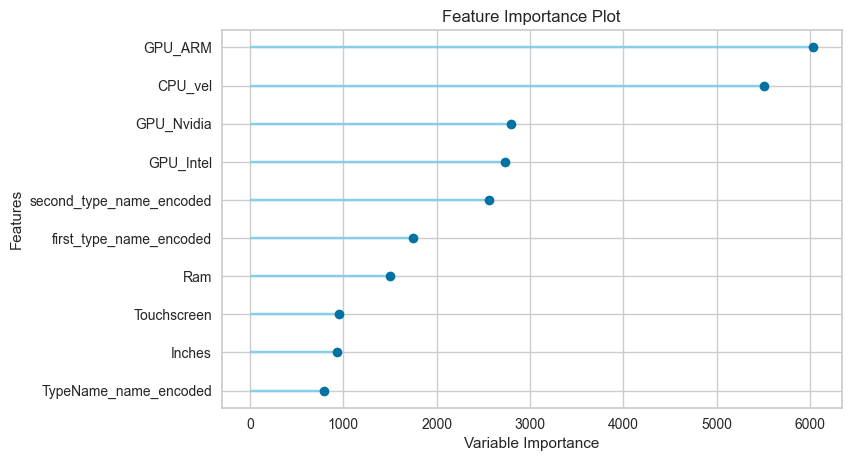

In [96]:
# Plot of Feature Importance
plot_model(lr2, plot='feature')

In [97]:
# print out the LRmodel,  線性回歸模型

print("Liner regression model:\nPrice = ")
for i in range(len(lr2.feature_names_in_)):
      print('\t',lr2.coef_[i]," ∘ ",lr2.feature_names_in_[i])

Liner regression model:
Price = 
	 -932.7188645953312  ∘  Inches
	 1505.6486020139341  ∘  Ram
	 5507.3063794397995  ∘  CPU_vel
	 2732.5047864433795  ∘  GPU_Intel
	 509.20982337832214  ∘  GPU_AMD
	 2792.9822679240947  ∘  GPU_Nvidia
	 -6034.696877746654  ∘  GPU_ARM
	 954.1276570010285  ∘  Touchscreen
	 546.9144195636406  ∘  Ips
	 -4.1489913582126405  ∘  X_res
	 19.63255263345178  ∘  Y_res
	 -16.30331453946627  ∘  ppi
	 -0.7732301648896964  ∘  first_size
	 -4.0528036001469445  ∘  second_size
	 137.14406336081728  ∘  Company_name_encoded
	 793.7482288958176  ∘  TypeName_name_encoded
	 369.51512474902006  ∘  Cpu_brand_name_encoded
	 1751.3423487781686  ∘  first_type_name_encoded
	 -2563.970790802448  ∘  second_type_name_encoded


Note
---
1. the most important feature is `GPU_ARM`? Why? Hint: Axxxx.
2. There is no significant  differce between GPU_Nvidia and GPU_Intel, surprised?
3. From the copmare_models, the best one model is `catboost`. Try to make a model by `catboost` scheme.

In [100]:

cat_model=create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4459.4459,54748019.6313,7399.1905,0.7984,0.2224,0.1810
1,3518.1314,26310870.9294,5129.4123,0.8520,0.2081,0.1675
2,4107.0422,30627080.4422,5534.1739,0.8492,0.1980,0.1626
3,3831.6790,30288841.6971,5503.5299,0.8455,0.2020,0.1653
4,3092.2662,20746417.6407,4554.8236,0.8631,0.2185,0.1733
5,4136.8719,34648770.6242,5886.3206,0.8539,0.2021,0.1634
6,4381.5375,52579028.8895,7251.1398,0.6711,0.2409,0.1901
7,4250.8361,35426146.2206,5951.9867,0.8008,0.2440,0.2059
8,4404.2550,44215612.7108,6649.4821,0.7729,0.2562,0.2071


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [102]:
pred_cat = predict_model(cat_model)
pred_cat

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,4011.3424,48639287.7364,6974.1872,0.7965,0.2132,0.1707


,Inches,Ram,CPU_vel,GPU_Intel,GPU_AMD,GPU_Nvidia,GPU_ARM,Touchscreen,Ips,X_res,...,ppi,first_size,second_size,Company_name_encoded,TypeName_name_encoded,Cpu_brand_name_encoded,first_type_name_encoded,second_type_name_encoded,Price,prediction_label
912,15.6,4.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1366.0,...,100.454666,0.0,0.0,0.0,3.0,24.0,1.0,2.0,9700,9074.219176
913,15.6,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1366.0,...,100.454666,1000.0,0.0,10.0,3.0,24.0,1.0,2.0,7000,8531.656602
914,15.6,8.0,2.5,0.0,1.0,0.0,0.0,0.0,0.0,1920.0,...,141.212006,256.0,0.0,7.0,5.0,26.0,3.0,2.0,31000,35003.664240
915,12.5,4.0,2.5,1.0,0.0,0.0,0.0,0.0,0.0,1366.0,...,125.367432,256.0,0.0,7.0,4.0,25.0,3.0,2.0,32300,30560.703106
916,14.0,8.0,2.6,0.0,0.0,1.0,0.0,1.0,1.0,1920.0,...,157.350510,512.0,0.0,10.0,0.0,26.0,3.0,2.0,42600,29750.700187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,15.6,16.0,2.8,0.0,0.0,1.0,0.0,0.0,0.0,1920.0,...,141.212006,256.0,1000.0,2.0,1.0,26.0,3.0,0.0,50800,35796.790592
1299,15.6,2.0,1.6,1.0,0.0,0.0,0.0,0.0,0.0,1366.0,...,100.454666,0.0,0.0,4.0,3.0,27.0,1.0,2.0,7800,7240.821716
1300,14.0,4.0,1.1,1.0,0.0,0.0,0.0,0.0,0.0,1920.0,...,157.350510,32.0,0.0,2.0,3.0,27.0,0.0,2.0,6100,7448.580549
1301,15.6,8.0,2.7,0.0,0.0,1.0,0.0,0.0,0.0,1920.0,...,141.212006,1000.0,0.0,7.0,3.0,26.0,1.0,2.0,18700,17968.123021


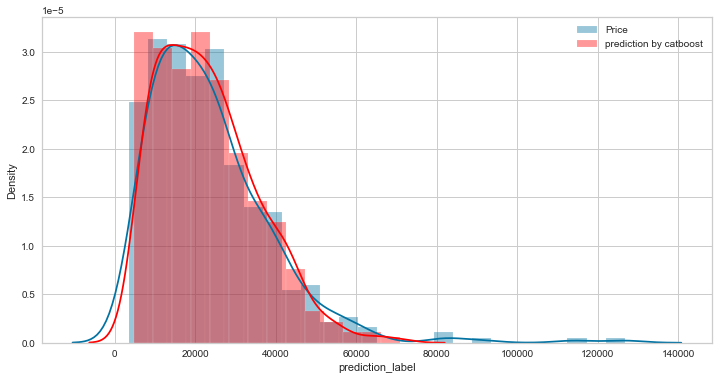

In [121]:
plt.figure(figsize=[12,6])
sns.distplot(pred_cat['Price'],label='Price')
sns.distplot(pred_cat['prediction_label'],color='red',label='prediction by catboost')
plt.legend()

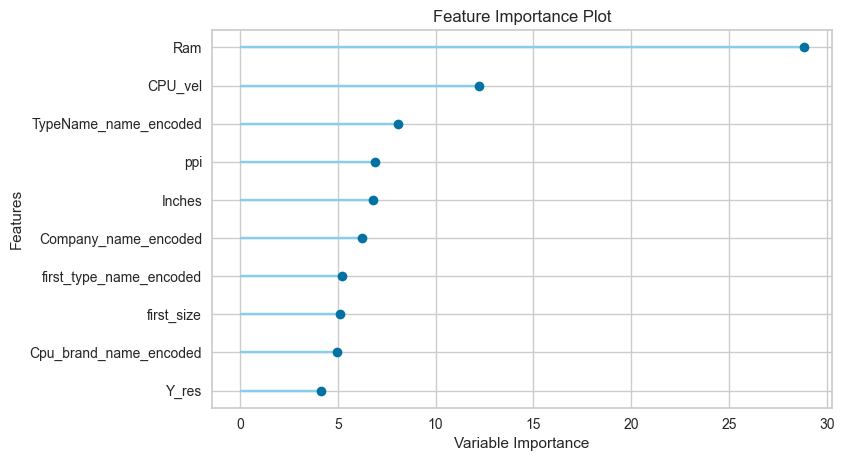

In [107]:
# Plot of Feature Importance
plot_model(cat_model, plot='feature')

<AxesSubplot: >

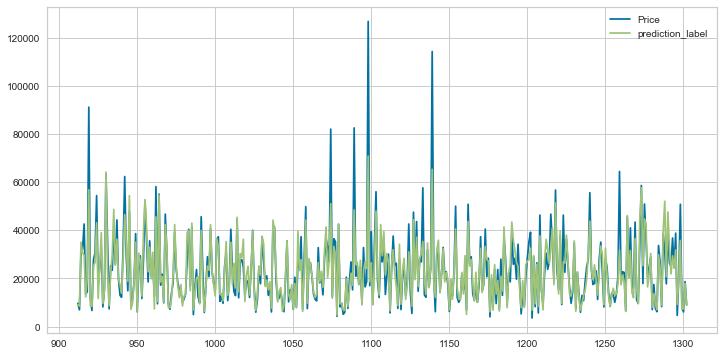

In [108]:
pred_cat[['Price','prediction_label']].plot(figsize=[12,6])

<font color="red">Note</font>
---
If no idea about what `graphviz` is, do not try to visualize the tree structure as follows, just use its prediction only! I don't know how to install graphviz in google drive too. 

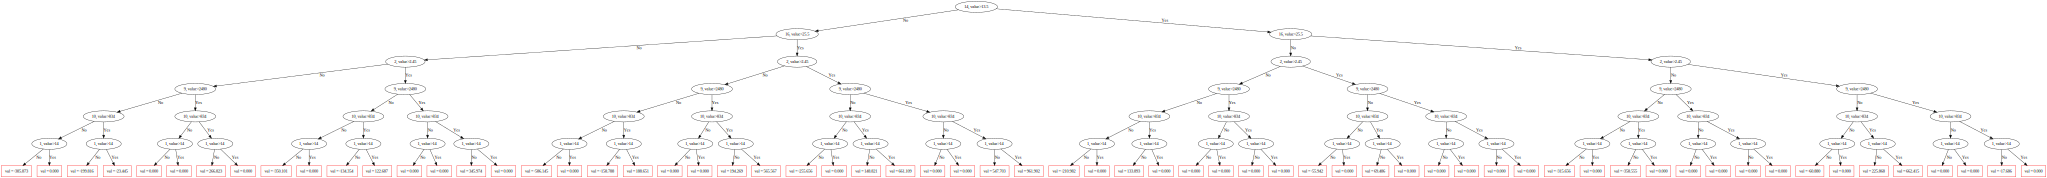

In [123]:
cat_model.plot_tree(tree_idx=0)

Self-learning
---
1. Conclude the the result of cat_model above.
2. Conclude the skills 